In [29]:
import math
import random
import matplotlib.pyplot as plt

# Variables aleatorias

En la celda inferior están implementados los métodos utilizados para generar todas las variables aleatorias necesarias para la simulación. 

In [30]:
def Exp(mean):
    lamda = 1 / mean
    return -1 * math.log(1 - random.random()) / lamda

def classicProbability(probability):
    val = random.random() * 100 
    return True if val < probability else False

def ArrivalTime():
    return Exp(1/20) * 60 

def RServiceTime():
    return Exp(4)

def PServiceTime():
    return Exp(5) 

def FromPToR():
    return classicProbability(10)
    
def FromRToP():
    return classicProbability(20)

def POrR():
    return classicProbability(40)

In [31]:
class Client:
    def __init__(self, arrivalP, departureP, arrivalR, departureR, bothMeals):
        self.arrivalP = arrivalP
        self.departureP = departureP
        self.arrivalR = arrivalR
        self.departureR = departureR
        
        self.bothMeals = bothMeals
        self.isFirstMeal = True
    
    def setSecondMeal(self):
        self.isFirstMeal = False
        
class Event:
    def __init__(self, eventName, time, clientId):
        self.time = time
        self.eventName = eventName
        self.clientId = clientId	
        

In [32]:
def ComputeValuesInSim(clientInfo, maxTime):
    WP = 0
    WR = 0
    WPR = 0
    WPCount = 0
    WRCount = 0
    WPRCount = 0

    for client in clientInfo.values():
        if client.departureP != -1 and client.departureR != -1:
            WPR += client.departureR - client.arrivalP if client.departureR > client.departureP else client.departureP - client.arrivalR
            WPRCount += 1
            
        if client.arrivalP != -1:
            WP += client.departureP - client.arrivalP if client.departureP != -1 else maxTime - client.arrivalP
            WPCount += 1
                     
        if client.arrivalR != -1:
            WR += client.departureR - client.arrivalR if client.departureR != -1 else maxTime - client.arrivalR
            WRCount += 1
        
        
    W = WP + WR
    
    if(WPCount + WRCount > 0):
        W /= len(clientInfo)
    if(WPCount > 0):
        WP /= WPCount
    if(WRCount > 0):
        WR /= WRCount
    if(WPRCount > 0):
        WPR /= WPRCount
    
    return len(clientInfo), W, WP, WR, WPR

# Simulación del problema original

In [33]:
def Sim1(ArrivalTime, RServiceTime, PServiceTime, FromPToR, FromRToP, POrR, maxTime):
    time = 0
    aT = ArrivalTime()
    dTP = float("inf")
    dTR = float("inf")
    lastClientId = -1 
    clientCount = 0
    L = 0
    LCount = 0
    
    qR = []
    qP = []

    isFreeP = True
    isFreeR = True
    clientOnP = -1
    clientOnR = -1
    
    eventList = []
    clientInfo = {}
    
    while time <= maxTime:
        _min = min(aT, dTR, dTP)    
        
        if _min == aT:
            time = aT
            aT = ArrivalTime() + time
            
            lastClientId += 1
            
            clientCount += 1
            L += clientCount
            LCount += 1
            
            if POrR():
                clientInfo[lastClientId] = Client(time, -1, -1, -1, False)
                eventList.append(Event("LLegada a la cola del pollo frito", time, lastClientId))
                qP.append(lastClientId)
                
                if isFreeP:
                    dTP = time + PServiceTime()
                    clientOnP = qP.pop(0)
                    eventList.append(Event("LLegada a la ventana del pollo frito", time, clientOnP))
                    isFreeP = False
                
            else:
                clientInfo[lastClientId] = Client(-1, -1, time, -1, False)
                eventList.append(Event("LLegada a la cola de los rollitos", time, lastClientId))
                qR.append(lastClientId)
                
                if isFreeR:
                    dTR = time + RServiceTime()
                    clientOnR = qR.pop(0)
                    eventList.append(Event("LLegada a la ventana de los rollitos", time, clientOnR))
                    isFreeR = False
                
        elif _min == dTP:
            time = dTP
            eventList.append(Event("Salida de la ventana del pollo frito", time, clientOnP))
            clientInfo[clientOnP].departureP = time
            
            if clientInfo[clientOnP].isFirstMeal and FromPToR():
                eventList.append(Event("Cambio a la cola de rollitos", time, clientOnP))
                clientInfo[clientOnP].arrivalR = time
                clientInfo[clientOnP].bothMeals = True
                clientInfo[clientOnP].setSecondMeal()
                qR.append(clientOnP)
            else:
                clientCount -= 1
                L += clientCount
                LCount += 1
                
            if len(qP) > 0:
                dTP = time + PServiceTime()
                clientOnP = qP.pop(0)
                eventList.append(Event("LLegada a la ventana del pollo frito", time, clientOnP))
                 
            else:
                dTP = float("inf")
                isFreeP = True 
            
        elif _min == dTR:
            time = dTR
            eventList.append(Event("Salida de la ventana de los rollitos", time, clientOnR))
            clientInfo[clientOnR].departureR = time
            
            if clientInfo[clientOnR].isFirstMeal and FromRToP():
                eventList.append(Event("Cambio a la cola del pollo frito", time, clientOnR))
                clientInfo[clientOnR].arrivalP = time
                clientInfo[clientOnR].bothMeals = True
                clientInfo[clientOnR].setSecondMeal()
                qP.append(clientOnR)
                
            else:
                clientCount -= 1
                L += clientCount
                LCount += 1
            
            if len(qR) > 0:
                dTR = time + RServiceTime()
                clientOnR = qR.pop(0)
                eventList.append(Event("LLegada a la ventana de los rollitos", time, clientOnR))
                
            else:
                dTR = float("inf")
                isFreeR = True 
    
    if(LCount > 0):
        L /= LCount
    
    clientCount, W, WP, WR, WPR = ComputeValuesInSim(clientInfo, maxTime)
    
    return clientCount, W, WP, WR, WPR, L

# Simulación con prioridad a la compra de ambos platos

In [34]:
def Sim2(ArrivalTime, RServiceTime, PServiceTime, FromPToR, FromRToP, POrR, maxTime):
    time = 0
    aT = ArrivalTime()
    dTP = float("inf")
    dTR = float("inf")
    lastClientId = -1 
    clientCount = 0
    L = 0
    LCount = 0
    
    qR = [] #volver una cola
    qRBoth = [] #cola rollitos despues de pollo
    qP = [] #volver una cola
    qPBoth = [] #cola pollo despues de rollitos

    isFreeP = True
    isFreeR = True
    clientOnP = -1
    clientOnR = -1
    
    eventList = []
    clientInfo = {}
    
    while time <= maxTime:
        _min = min(aT, dTR, dTP)    
        
        if _min == aT:
            time = aT
            aT = ArrivalTime() + time
            
            lastClientId += 1
                
            clientCount += 1
            L += clientCount
            LCount += 1
            
            if POrR():
                _fromPtoR = FromPToR()
                
                clientInfo[lastClientId] = Client(time, -1, -1, -1, _fromPtoR)
                eventList.append(Event("LLegada a la cola del pollo frito", time, lastClientId))
                
                if _fromPtoR:
                    qPBoth.append(lastClientId) 
                else:
                    qP.append(lastClientId)
                
                if isFreeP:
                    dTP = time + PServiceTime()
                    clientOnP = qPBoth.pop(0) if len(qPBoth) > 0 else qP.pop(0)
                    eventList.append(Event("LLegada a la ventana del pollo frito", time, clientOnP))
                    isFreeP = False
            else:
                _fromRtoP = FromRToP()
                
                clientInfo[lastClientId] = Client(-1, -1, time, -1, _fromRtoP)
                eventList.append(Event("LLegada a la cola de los rollitos", time, lastClientId))
                
                if _fromRtoP:
                    qRBoth.append(lastClientId)
                else:                
                    qR.append(lastClientId)
                
                if isFreeR:
                    dTR = time + RServiceTime()
                    clientOnR = qRBoth.pop(0) if len(qRBoth) > 0 else qR.pop(0)
                    eventList.append(Event("LLegada a la ventana de los rollitos", time, clientOnR))
                    isFreeR = False
         
                
        elif _min == dTP:
            time = dTP
            eventList.append(Event("Salida de la ventana del pollo frito", time, clientOnP))
            clientInfo[clientOnP].departureP = time
            
            if clientInfo[clientOnP].bothMeals and clientInfo[clientOnP].isFirstMeal:
                eventList.append(Event("Cambio a la cola de rollitos", time, clientOnP))
                clientInfo[clientOnP].arrivalR = time
                clientInfo[clientOnP].setSecondMeal()
                qRBoth.append(clientOnP)
            else:
                clientCount -= 1
                L += clientCount
                LCount += 1

            if len(qPBoth) > 0:
                dTP = time + PServiceTime()
                clientOnP = qPBoth.pop(0)
                eventList.append(Event("LLegada a la ventana del pollo frito", time, clientOnP)) 
                
            elif len(qP) > 0:
                dTP = time + PServiceTime()
                clientOnP = qP.pop(0)
                eventList.append(Event("LLegada a la ventana del pollo frito", time, clientOnP))
                 
            else:
                dTP = float("inf")
                isFreeP = True 
            
        elif _min == dTR:
            time = dTR
            eventList.append(Event("Salida de la ventana de los rollitos", time, clientOnR))
            clientInfo[clientOnR].departureR = time
            
            if clientInfo[clientOnR].bothMeals and clientInfo[clientOnR].isFirstMeal:
                eventList.append(Event("Cambio a la cola del pollo frito", time, clientOnR))
                clientInfo[clientOnR].arrivalP = time
                clientInfo[clientOnR].setSecondMeal()
                qPBoth.append(clientOnR)
                
            else:
                clientCount -= 1
                L += clientCount
                LCount += 1

            if len(qRBoth) > 0:
                dTR = time + RServiceTime()
                clientOnR = qRBoth.pop(0)
                eventList.append(Event("LLegada a la ventana de los rollitos", time, clientOnR))   
            
            elif len(qR) > 0:
                dTR = time + RServiceTime()
                clientOnR = qR.pop(0)
                eventList.append(Event("LLegada a la ventana de los rollitos", time, clientOnR))
                
            else:
                dTR = float("inf")
                isFreeR = True 
    
    if(LCount > 0):
        L /= LCount
        
    clientCount, W, WP, WR, WPR = ComputeValuesInSim(clientInfo, maxTime)
    
    return clientCount, W, WP, WR, WPR, L
    

In [35]:
def ComputeVar(Sim, index, iters, simulationResults, d, time):
    Xj = sum([simulation[index] for simulation in simulationResults]) / iters
    Varj = sum([((simulation[index] - Xj)**2) / (iters - 1) for simulation in simulationResults])    

    while math.sqrt(Varj/ iters) >= d:
        iters += 1
        simulationResults.append(Sim(ArrivalTime, RServiceTime, PServiceTime, FromPToR, FromRToP, POrR, time))
        Xj1 = Xj
        Xj = Xj + (simulationResults[-1][index] - Xj) / (iters + 1)
        Varj = (1 - 1/iters) * Varj + (iters + 1)*((Xj - Xj1)**2)

    
    return Xj, iters, Varj

In [36]:
def ComputeValues(Sim, time):
    dTime = 0.1666
    dClients = 1
    
    iters = 100
    
    print("################### Iniciando Simualcion ###################")
    
    simulationResults = [Sim(ArrivalTime, RServiceTime, PServiceTime, FromPToR, FromRToP, POrR, 10080) for i in range(iters)]

    Wj, iters, WVarj = ComputeVar(Sim, 1, iters, simulationResults, dTime, time)
    print("Cantidad de interaciones realizadas:", iters, "Estimación de W", Wj, "Con varianza:", WVarj)
    
    WPj, iters, WPVarj = ComputeVar(Sim, 2, iters, simulationResults, dTime, time)
    print("Cantidad de interaciones realizadas:", iters, "Estimación de P", WPj, "Con varianza:", WPVarj)
    
    WRj, iters, WRVarj = ComputeVar(Sim, 3, iters, simulationResults, dTime, time)
    print("Cantidad de interaciones realizadas:", iters, "Estimación de R", WRj, "Con varianza:", WRVarj)
    
    WPRj, iters, WPRVarj = ComputeVar(Sim, 4, iters, simulationResults, dTime, time)
    print("Cantidad de interaciones realizadas:", iters, "Estimación de PR", WPRj, "Con varianza:", WPRVarj)
    
    Lj, iters, LVarj = ComputeVar(Sim, 5, iters, simulationResults, dClients, time)
    print("Cantidad de interaciones realizadas:", iters, "Estimación de L", Lj, "Con varianza:", LVarj)
    

In [37]:
ComputeValues(Sim1, 10080)
ComputeValues(Sim2, 10080)

################### Iniciando Simualcion ###################
Cantidad de interaciones realizadas: 2169 Estimación de W 36.945513181781756 Con varianza: 60.17375128078904
Cantidad de interaciones realizadas: 4743 Estimación de P 37.882439111896105 Con varianza: 131.64129950894778
Cantidad de interaciones realizadas: 4743 Estimación de R 26.85446015676669 Con varianza: 46.6244740628391
Cantidad de interaciones realizadas: 6872 Estimación de PR 65.55166730328183 Con varianza: 190.70831584260708
Cantidad de interaciones realizadas: 6872 Estimación de C 12.826713655811783 Con varianza: 7.537819269082322
################### Iniciando Simualcion ###################
Cantidad de interaciones realizadas: 2206 Estimación de W 37.360526382215674 Con varianza: 61.19358883653936
Cantidad de interaciones realizadas: 4842 Estimación de P 38.17662984016399 Con varianza: 134.3668250485684
Cantidad de interaciones realizadas: 4842 Estimación de R 27.082631855193046 Con varianza: 49.01997395597875
Cantida

-0.415013200433918
0.02774262391922039649608114338405
0.0277396141598093200362647325476

0.23554667919338136262780746851426

-1.7619148860646704278033819709783

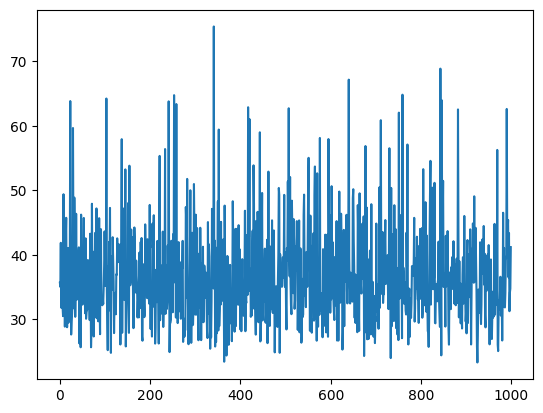

In [38]:
simulationResults = [Sim1(ArrivalTime, RServiceTime, PServiceTime, FromPToR, FromRToP, POrR, 10080) for i in range(1000)]

plt.plot([simulationResult[1] for simulationResult in simulationResults])

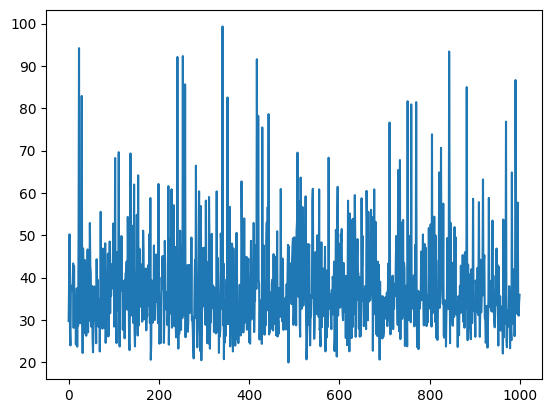

In [39]:
plt.plot([simulationResult[2] for simulationResult in simulationResults])

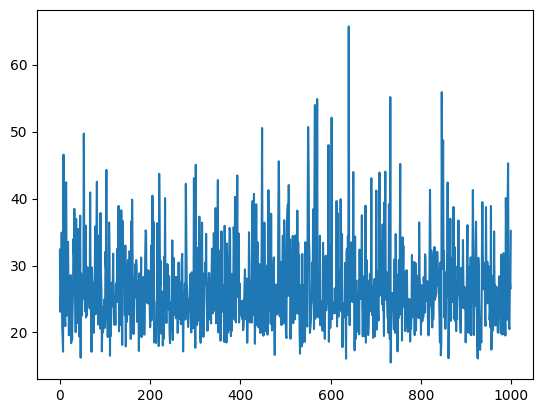

In [40]:
plt.plot([simulationResult[3] for simulationResult in simulationResults])

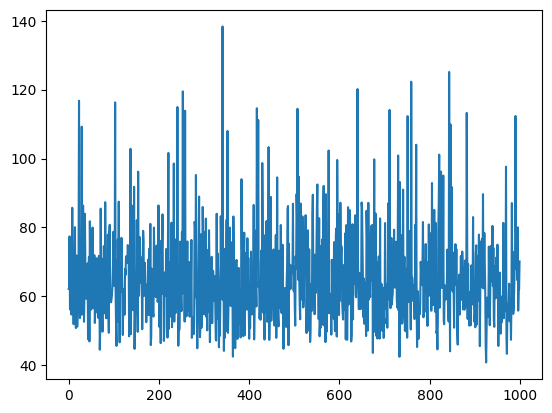

In [41]:
plt.plot([simulationResult[4] for simulationResult in simulationResults])

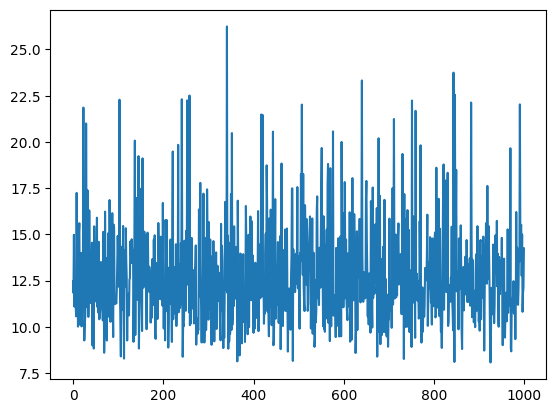

In [42]:
plt.plot([simulationResult[5] for simulationResult in simulationResults])